# 2D Vectorized Random Walk

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [2]:
def plot_random_walks(num_steps):
    x = np.zeros(num_steps)
    y = np.zeros(num_steps)
    
    for i in range(1, num_steps):
        theta = random.uniform(0, 1)*2*math.pi
        dx = math.sin(theta)
        dy = math.cos(theta)
        x[i] = x[i-1] + dx
        y[i] = y[i-1] + dy
    
    plt.plot(x, y, "b-", label='Path', zorder=1)
    plt.scatter(x[0], y[0], c="red", marker='o', label='Starting point', zorder=2)
    plt.scatter(x[-1], y[-1], c="red", marker='*', label='End point', zorder=2)
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"2D Random Walks in {num_steps} Steps")
    plt.legend()
    plt.show()

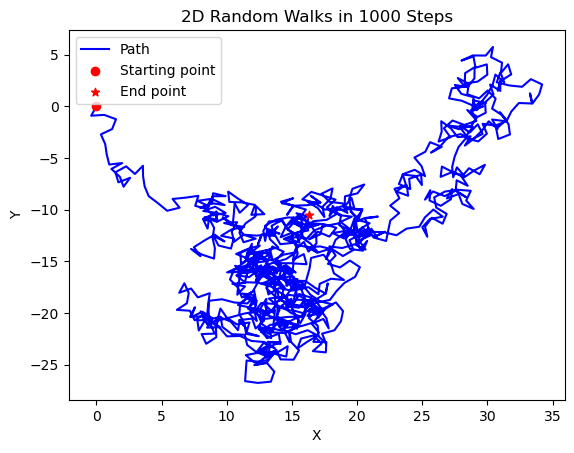

In [3]:
plot_random_walks(1000)

## 2D Vectorized Random Walk with Characters

### Starting point
- Map size is 50 by 50 rectangular map.
- Villager and Hunter are at origin. Monster will appear in random position.  

### Basic stats
- All Villager, Monster and Hunter will perform random walk inside the map at first at a speed of 1 unit-length per move.  
- They all have 2 unit-lengths of vision distance.  
- Monster and Hunter have 1 unit-length of attack range and Hunter will always win against Monster.  
- They have different agilities: Villager moves the first, Monster the second, and Hunter moves last.  

### Rules of motion upon encounter
- Villager will escape from Monster.  
- Monster will chase the closer one of both Villager and Hunter. 
- Once Monster hunts down the target it will continue random walk.  
- Hunter will chase and hunt Monster.  
- The motion will end when Monster is eliminated or the movement limit is reached.


In [4]:
class Character:
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y
        self.path_x = [x]
        self.path_y = [y]
        self.alive = True

    def move(self, dx, dy):
        self.x += dx
        self.y += dy
        self.path_x.append(self.x)
        self.path_y.append(self.y)

    def random_move(self, x_min, x_max, y_min, y_max):
        while True:
            theta = random.uniform(0, 1)*2*math.pi
            dx = math.sin(theta)
            dy = math.cos(theta)
            new_x, new_y = self.x + dx, self.y + dy
            if x_min <= new_x <= x_max and y_min <= new_y <= y_max:
                self.move(dx, dy)
                break

    def distance_to(self, other):
        return math.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)
    
    def direction_to(self, other):
        return math.atan((other.y - self.y) / (other.x - self.x))

def plot_motion_simulation(num_steps, chars, current_map):
    # Get map size
    hor, ver = zip(*current_map)
    x_min, x_max = min(hor), max(hor)
    y_min, y_max = min(ver), max(ver)

    # Setting up initial conditions
    villager = Character()
    hunter   = Character()
    monster  = Character(np.random.randint(x_min, x_max), np.random.randint(y_min, y_max))

    v_agil = chars['villager']['agility']
    h_agil = chars['hunter']['agility']
    m_agil = chars['monster']['agility']
    agilities = sorted([v_agil, h_agil, m_agil])

    v_attack = chars['villager']['attack']
    h_attack = chars['hunter']['attack']
    m_attack = chars['monster']['attack']

    # v_range = chars['villager']['range']
    h_range = chars['hunter']['range']
    m_range = chars['monster']['range']

    v_vision = chars['villager']['vision']
    h_vision = chars['hunter']['vision']
    m_vision = chars['monster']['vision']

    for step in range(num_steps):
        for i in agilities:
            # Villager's move
            if i == v_agil and villager.alive:
                if villager.distance_to(monster) <= v_vision:
                    dx = -math.cos(villager.direction_to(monster)) if villager.x < monster.x else math.cos(villager.direction_to(monster))
                    dy = -math.sin(villager.direction_to(monster)) if villager.y < monster.y else math.sin(villager.direction_to(monster))
                    villager.move(dx, dy) 
                else:
                    villager.random_move(x_min, x_max, y_min, y_max)

            # Hunter's move
            if i == h_agil and hunter.alive:
                if hunter.distance_to(monster) <= h_vision:
                    dx = math.cos(hunter.direction_to(monster)) if hunter.x < monster.x else -math.cos(hunter.direction_to(monster))
                    dy = math.sin(hunter.direction_to(monster)) if hunter.y < monster.y else -math.sin(hunter.direction_to(monster))
                    hunter.move(dx, dy)
                else:
                    hunter.random_move(x_min, x_max, y_min, y_max)

            # Monster's move
            if i == m_agil and monster.alive:
                target = villager if villager.distance_to(monster) < hunter.distance_to(monster) and villager.alive else hunter
                if monster.distance_to(target) <= m_vision:
                    dx = math.cos(monster.direction_to(target)) if hunter.x < monster.x else -math.cos(monster.direction_to(target))
                    dy = math.sin(monster.direction_to(target)) if hunter.y < monster.y else -math.sin(monster.direction_to(target))
                    monster.move(dx, dy)
                else:
                    monster.random_move(x_min, x_max, y_min, y_max)

        # Check villager alive
        if villager.distance_to(monster) <= m_range and villager.alive:
            villager.alive = False
            print(f"Villager eliminated at step {step+1}")

        # Check for end conditions
        if hunter.distance_to(monster) <= h_range:
            monster.alive = False
            print(f"Monster eliminated at step {step+1}")
            break

    # Plotting the paths
    plt.plot(villager.path_x, villager.path_y, c='lime', label='Villager Path', zorder=v_agil)
    plt.plot(hunter.path_x, hunter.path_y,c='blue', label='Hunter Path', zorder=h_agil)
    plt.plot(monster.path_x, monster.path_y, c='red', label='Monster Path', zorder=m_agil)

    # Mark the final positions
    plt.scatter(villager.path_x[-1], villager.path_y[-1], c='green', marker='o', label='Villager Final Position', zorder=v_attack*10)
    plt.scatter(hunter.path_x[-1], hunter.path_y[-1], c='navy', marker='o', label='Hunter Final Position', zorder=h_attack*10)
    plt.scatter(monster.path_x[-1], monster.path_y[-1], c='brown', marker='o', label='Monster Final Position', zorder=m_attack*10)

    plt.xlim(min(current_map[:, 0])-1, max(current_map[:, 0]+1))
    plt.ylim(min(current_map[:, 1])-1, max(current_map[:, 1]+1))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'2D Random Walk Simulation with Characters in {num_steps} Steps')
    plt.legend()
    plt.show()


Villager eliminated at step 1305
Monster eliminated at step 1995


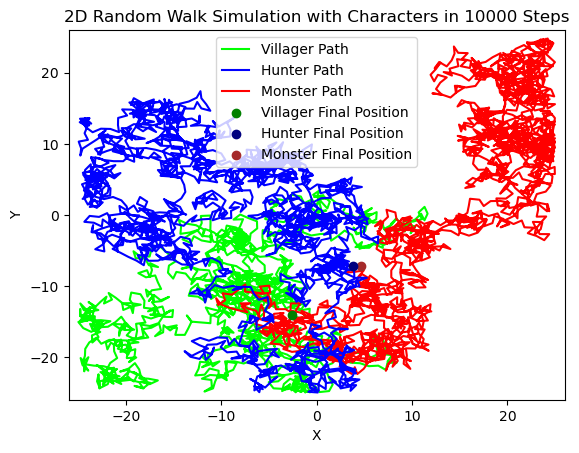

In [5]:
villager = {
    'agility' : 0,
    'attack'  : 1,
    'vision'  : 2,
    'range'  : None,
    'movement': np.array([(0, 1), (0, -1), (1, 0), (-1, 0)])
}

monster = {
    'agility' : 1,
    'attack'  : 2,
    'vision'  : 2,
    'range'  : 1,
    'movement': np.array([(0, 1), (0, -1), (1, 0), (-1, 0)])
}

hunter = {
    'agility' : 2,
    'attack'  : 3,
    'vision'  : 2,
    'range'  : 1,
    'movement': np.array([(0, 1), (0, -1), (1, 0), (-1, 0)])
}

characters = {
    'villager': villager,
    'monster' : monster,
    'hunter'  : hunter
}

current_map = np.array([
    (-25, 25) , (25, 25),
    (-25, -25), (25, -25)
]) # Rectangle map with integer vertices

steps = 10000

plot_motion_simulation(steps, characters, current_map)

### Ideas to be implemented:
- ~~Different stats for each character.~~  
- Different numbers of characters and more character types.  
- Irregular map shape ~~and vectorized movements~~.  
- Map is the surface of a sphere (no boundaries and object moving towards one direction will return to its origin position).
- Map has shelters/obstacles and limited amount of resources instead of using movement limit.
- (Some) resources are renewable.